# DevOps Engineer Interview Project
**Author : Felix Yuzhou Sun**

## 0. Introduction

In the context of financial analysis, accurately extracting Earnings Per Share (EPS) data from regulatory filings is essential for investors, analysts, and financial professionals. This task, often complicated by the diverse formats and structures of financial documents, requires a robust and adaptable parsing solution.

This project involves developing a parser to extract EPS data from SEC EDGAR filings in HTML format, as part of an assessment for a DevOps Engineer Interview at Trexquant Investment LP. The primary objective is to create a versatile parser that can handle various filing formats, systematically extract the latest quarterly EPS for each company, and present this data in a structured CSV format.

The development and testing of this parser are grounded in the analysis of 50 provided HTML files, focusing on identifying common patterns, handling variations, and ensuring the parser's adaptability to unseen document formats. The outcome of this project will be a reliable tool capable of facilitating informed financial decision-making through accurate data extraction.

## 1. Understanding the data

To build a robust parser, we will meticulously analyze the 50 training filings, identifying the common patterns and locations where EPS data is typically reported. This analysis will encompass recognizing keywords, table structures, and contextual cues that signal the presence of relevant information. We will also pay close attention to potential inconsistencies and edge cases, ensuring our parser's accuracy and adaptability across different EDGAR filings.

In [1]:
# Set Up Environment
%pip install beautifulsoup4 lxml pandas html5lib
%pip install spacy
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 28.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [1]:
import os
from bs4 import BeautifulSoup
import pandas as pd
import re
from collections import defaultdict

In [2]:
# Check the html data
current_directory = os.getcwd()
data_directory  = 'Training_Filings'
data_path = os.path.join(current_directory, data_directory)
print(f"Current working directory: {current_directory}")
print(data_path)

# Verify the data size
html_files = [f for f in os.listdir(data_path) if f.endswith('.html')]
# Total number of files
total_files = len(html_files)
print(f"Found {total_files} HTML files.")

Current working directory: /home/bbharbinger/Projects/EPS_Paser
/home/bbharbinger/Projects/EPS_Paser/Training_Filings
Found 50 HTML files.


### A. Tag Analysis

In [3]:
%%time
# Dictionary to hold the number of files in which each tag appears
tag_file_count = defaultdict(int)

# Iterate through all files and count tags
for file in html_files:
    filepath = os.path.join(data_path, file)
    
    with open(filepath, 'r', encoding='utf-8') as html_file:
        soup = BeautifulSoup(html_file, 'html.parser')
        
        # Extract unique tags from the current file
        unique_tags_in_file = set(tag.name for tag in soup.find_all(True))
        
        # Update the count of each tag, but only once per file
        for tag in unique_tags_in_file:
            tag_file_count[tag] += 1

# Calculate the percentage of files in which each tag appears
tag_percentage = {tag: (count / total_files) * 100 for tag, count in tag_file_count.items()}

# Sort the tags by percentage in descending order
sorted_tags = sorted(tag_percentage.items(), key=lambda item: item[1], reverse=True)

# Print results
print(f"{'Tag':<15}{'Files':<10}{'Percentage':<10}")
for tag, percentage in sorted_tags:
    print(f"{tag:<15}{tag_file_count[tag]:<10}{percentage:<10.2f}%")

Tag            Files     Percentage
body           50        100.00    %
type           50        100.00    %
document       50        100.00    %
sequence       50        100.00    %
font           50        100.00    %
table          50        100.00    %
html           50        100.00    %
filename       50        100.00    %
td             50        100.00    %
text           50        100.00    %
tr             50        100.00    %
description    49        98.00     %
div            49        98.00     %
title          49        98.00     %
br             46        92.00     %
hr             42        84.00     %
sup            38        76.00     %
img            36        72.00     %
a              26        52.00     %
p              23        46.00     %
b              14        28.00     %
u              13        26.00     %
i              8         16.00     %
ul             4         8.00      %
li             4         8.00      %
center         4         8.00      %
h2

#### Tag analysis results

| Tag 1         | Files | Percentage | Tag 2         | Files | Percentage |
|---------------|-------|------------|---------------|-------|------------|
| body          | 50    | 100.00%    | br            | 46    | 92.00%     |
| document      | 50    | 100.00%    | hr            | 42    | 84.00%     |
| filename      | 50    | 100.00%    | sup           | 38    | 76.00%     |
| font          | 50    | 100.00%    | img           | 36    | 72.00%     |
| html          | 50    | 100.00%    | a             | 26    | 52.00%     |
| sequence      | 50    | 100.00%    | p             | 23    | 46.00%     |
| table         | 50    | 100.00%    | b             | 14    | 28.00%     |
| td            | 50    | 100.00%    | u             | 13    | 26.00%     |
| text          | 50    | 100.00%    | i             | 8     | 16.00%     |
| tr            | 50    | 100.00%    | ul            | 4     | 8.00%      |
| type          | 50    | 100.00%    | li            | 4     | 8.00%      |
| title         | 49    | 98.00%     | center        | 4     | 8.00%      |
| description   | 49    | 98.00%     | h1            | 3     | 6.00%      |
| div           | 49    | 98.00%     | h2            | 3     | 6.00%      |
| em            | 1     | 2.00%      | meta          | 2     | 4.00%      |
| strike        | 1     | 2.00%      | strong        | 1     | 2.00%      |



#### Insights from the Tag Analysis


1. **Core Tags (`table`, `td`, `tr`)**:
   - **High Occurrence (100%)**: Tags like `<table>`, `<td>`, `<tr>`, and related tags appear in every document. This indicates that EPS data, which is typically presented in tabular format, is consistently structured within tables. Therefore, the parser should primarily focus on searching within `<table>` tags to locate EPS values.

2. **Document Structure (`html`, `body`, `title`)**:
   - **High Occurrence (100%)**: Tags such as `<html>`, `<body>`, and `<title>` are present in every file, indicating that all documents follow a well-defined HTML structure. The `<title>` tag, which often contains the document's title, might give context (e.g., the company name or report type) that could help identify relevant sections of the document.

3. **Financial Data Tags (`sup`, `sub`)**:
   - **Moderate Occurrence (76%, 84%)**: Tags like `<sup>` (often used for superscripts like footnotes) might be associated with small notations beside financial data, including EPS figures. These tags are important for handling any associated footnotes or references that could alter the interpretation of the EPS data (e.g., adjustments for extraordinary items).
   
4. **Formatting Tags (`font`, `br`, `hr`, `b`)**:
   - **High to Moderate Occurrence**: Tags like `<font>`, `<br>`, and `<b>` indicate that the documents use various formatting styles to highlight or structure the data. Bold tags (`<b>`) often emphasize key financial metrics, including EPS.

### B. Recognize "Earnings Per Share" patterms

"Earnings Per Share" (EPS) might appear in various forms, including abbreviations, acronyms, or even partially spaced out versions like "E...P...S...". We need to capture not just standard forms like "EPS" or "Earnings Per Share," but also non-standard forms like "E... P... S..." or "earnings p/share." 

#### High-Level Methodology:

1. **Isolate Relevant Sections**:
   - **Goal**: Focus on parts of the document that are likely to contain EPS-related information, primarily the tables.
   - **Method**: Extract all `<table>` elements from each HTML file since these sections are structured and likely contain financial data.

2. **Tokenize Content**:
   - **Goal**: Break down the table content into manageable pieces (tokens) to identify relevant information.
   - **Method**: Treat each cell within a table (`<td>` or `<th>`) as a token. These tokens will contain words or phrases that can be analyzed individually.

3. **Pattern Matching**:
   - **Goal**: Identify tokens that are likely to be related to EPS by searching for specific keywords or phrases.
   - **Method**: Look for the presence of certain key components within each token, such as:
     - **"earn"**: Captures "earnings," "earn," "earning," etc.
     - **"per"**: Relevant for identifying "per share."
     - **"share"**: Specifically targets mentions of shares.
     - **"loss"**: Captures contexts like "net income (loss)" or "earnings (loss) per share."

4. **Contextual Analysis**:
   - **Goal**: Ensure the identified tokens are relevant to EPS and not unrelated financial terms (like "expenses").
   - **Method**: Consider the context in which these tokens appear. This involves checking the neighboring tokens or phrases to confirm they relate to EPS (e.g., "net income (loss)" or "GAAP earnings per share").

5. **Extraction and Aggregation**:
   - **Goal**: Extract the relevant phrases or terms and aggregate them across all documents.
   - **Method**: Combine tokens that are identified as related to EPS into complete phrases, and track their occurrences across all files.

6. **Generalization**:
   - **Goal**: Develop a robust approach that can handle variations in how EPS is presented across different documents.
   - **Method**: Use the patterns identified to create generalized rules that can be applied to other datasets.




         

#### Exploratory Text Mining

In [4]:
import os
from bs4 import BeautifulSoup
from spacy.matcher import Matcher
from collections import defaultdict
from tqdm import tqdm

**We start with finding out tokens with "per" and "share", then try to narrow down the patterm.**

In [5]:
# Function to extract tables from HTML content
def extract_tables(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    return soup.find_all('table')

# Function to tokenize content from a table
def tokenize_table(table):
    tokens = []
    for row in table.find_all('tr'):
        for cell in row.find_all(['td', 'th']):
            tokens.append(cell.get_text(strip=True).lower())
    return tokens

# Simplified function to match tokens that contain "per" and "share"
def match_eps_patterns(tokens):
    eps_related_phrases = []
    for token in tokens:
        if 'per' in token and 'share' in token or 'eps' in token:  # Only check for "per" and "share" or EPS
            eps_related_phrases.append(token)
    return eps_related_phrases

# Function to filter out irrelevant phrases
def filter_relevant_phrases(phrases):
    relevant_phrases = []
    for phrase in phrases:
        # Additional filtering logic to remove irrelevant terms
        if 'expenses' not in phrase and 'expectations' not in phrase:
            relevant_phrases.append(phrase)
    return relevant_phrases

# Function to aggregate EPS-related data across all HTML files
def aggregate_eps_data(html_files):
    eps_data = defaultdict(set)
    files_with_matches = 0  # Counter for files with at least one match

    for file in tqdm(html_files, desc="Processing files"):
        filepath = os.path.join(data_path, file)
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()
            tables = extract_tables(content)
            file_has_match = False  # Track if this file has at least one match

            for table in tables:
                tokens = tokenize_table(table)
                eps_phrases = match_eps_patterns(tokens)
                relevant_phrases = filter_relevant_phrases(eps_phrases)

                if relevant_phrases:
                    file_has_match = True
                    eps_data[file].update(relevant_phrases)

            if file_has_match:
                files_with_matches += 1  # Increment counter if a match is found

    return eps_data, files_with_matches

In [6]:
%%time
# Run the aggregation function and print the results
eps_data, files_with_matches = aggregate_eps_data(html_files)

# Print the number of files with at least one match
total_files = len(html_files)
print(f"\nNumber of files with at least one match: {files_with_matches} out of {total_files}")


Processing files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing files: 100%|██████████| 50/50 [00:05<00:00, 10.00it/s]


Number of files with at least one match: 50 out of 50
CPU times: user 4.99 s, sys: 19.3 ms, total: 5.01 s
Wall time: 5.01 s


In [7]:
# Print the set of EPS candidates for each file
for file, eps_set in eps_data.items():
    print(f"\nFile: {file}")
    print("EPS-related Phrases:")
    for phrase in eps_set:
        print(f"  - {phrase}")


File: 0000875320-20-000014.html
EPS-related Phrases:
  - gaap net income per share - diluted
  - (in millions, except per share amounts)
  - shares used in per share calculations:
  - shares used in diluted per share calculations:
  - net income per common share:
  - non-gaap net income per share - diluted
  - net income per diluted common share:

File: 0001165002-20-000083.html
EPS-related Phrases:
  - earnings per share:
  - economic eps
  - dividends declared per share

File: 0001423689-20-000040.html
EPS-related Phrases:
  - (in millions, except per share data)
  - net income (loss) per common share - basic
  - comprehensive income (loss) per common share - basic
  - $13.62tangible net book value per common share as ofmarch 31, 2020
  - net spread and dollar roll income, excluding "catch-up" premium amortization, per common share - basic
  - net spread and dollar roll income, excluding "catch-up" premium amortization, per common share - diluted
  - excludes$(0.44)per common share 

#### Insights from the outputs

**As the information above shows:**

- EPS-related phrases often contain a mix of short, meaningful tokens (like "earnings per share").

- Longer, descriptive sentences are not directly useful for locating EPS values.

<br>

**Next Steps:**

- **Plotting a Histogram**: We'll create a histogram to visualize the distribution of token lengths. This will help us determine a logical cut-off point for filtering.

- **Applying the Filter**: Once the cut-off point is set up, we'll filter out tokens that exceed this length, focusing only on the shorter, more relevant tokens.



In [8]:
token_lengths = []

# Calculate the length of each phrase and store it in the list
for eps_set in eps_data.values():
    for phrase in eps_set:
        token_lengths.append(len(phrase))


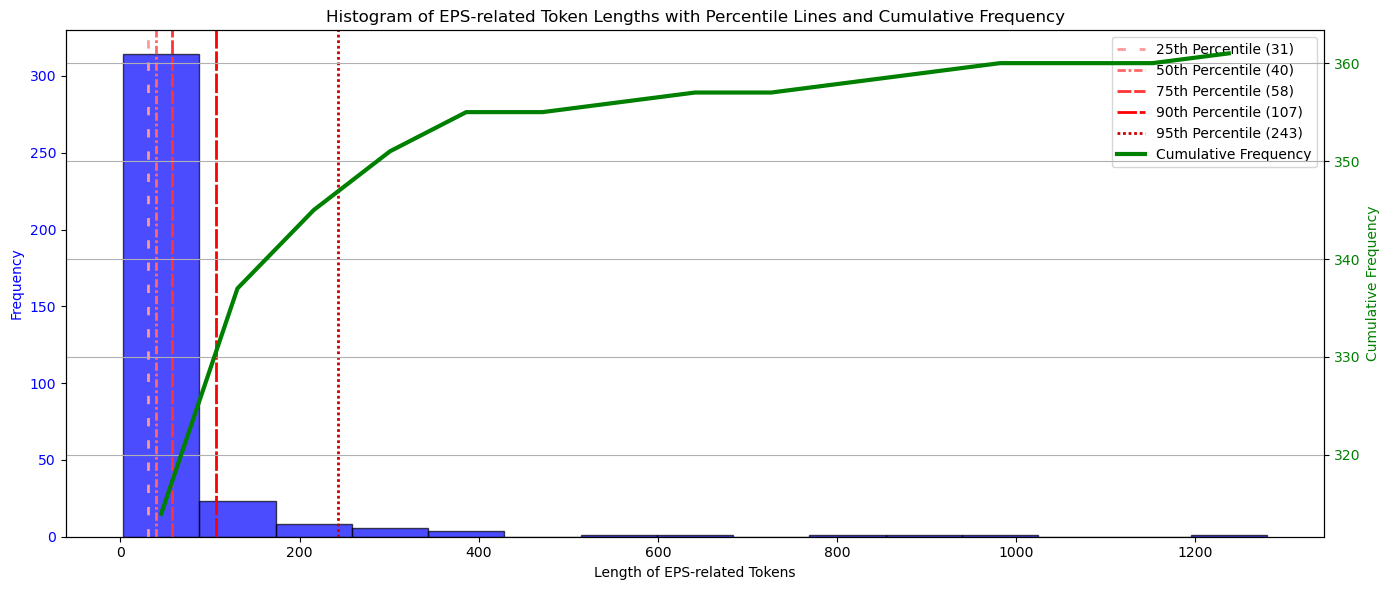

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the percentiles
percentiles = [25, 50, 75, 90, 95]
percentile_values = np.percentile(token_lengths, percentiles)

# Create the histogram and cumulative frequency
hist, bins = np.histogram(token_lengths, bins=15)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
cumulative_freq = np.cumsum(hist)

# Define different line styles and colors for each percentile
line_styles = [(0, (3, 5)), (0, (3, 1, 1, 1)), (0, (5, 1)), (0, (7, 1)), (0, (1, 1))]
colors = ['#ff9999', '#ff6666', '#ff3333', '#ff0000', '#cc0000']

# Create the figure and the first y-axis for the histogram
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.bar(bin_centers, hist, width=bins[1] - bins[0], color='blue', alpha=0.7, edgecolor='black')
ax1.set_xlabel("Length of EPS-related Tokens")
ax1.set_ylabel("Frequency", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot percentile lines with different line styles and colors
for perc, value, style, color in zip(percentiles, percentile_values, line_styles, colors):
    ax1.axvline(value, color=color, linestyle=style, linewidth=2, label=f'{perc}th Percentile ({int(value)})')

# Create a secondary y-axis for the cumulative frequency
ax2 = ax1.twinx()
ax2.plot(bin_centers, cumulative_freq, color='green', linestyle='-', linewidth=3, label="Cumulative Frequency")
ax2.set_ylabel("Cumulative Frequency", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add a legend and move it to the top right
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title("Histogram of EPS-related Token Lengths with Percentile Lines and Cumulative Frequency")

fig.tight_layout()  # Adjust the layout to accommodate both y-axes
plt.grid(True)
plt.show()


#### Insights from the Token Length Analysis

- **Percentile-Based Analysis**: The 25th percentile is at 32 characters, the 50th percentile at 40 characters, and the 75th percentile at 59 characters. This indicates that 75% of the relevant tokens are within 59 characters.

- **Potential Cut-off Point**: Based on the percentile analysis and the cumulative frequency curve, a reasonable cut-off point for filtering relevant EPS-related tokens might be around 100 characters. This cut-off would capture about 90% of the relevant tokens while excluding the longer, less relevant descriptive sentences.

In [10]:
# Define the cut-off length
cut_off_length = 100

# Initialize counters for total before and after filtering
total_before_filtering = 0
total_after_filtering = 0

# Initialize dictionary to store the filtered EPS data
filtered_eps_data = {}

# Iterate over the files and apply the filtering
for file, eps_set in eps_data.items():
    before_count = len(eps_set)  # Count before filtering
    filtered_eps_set = {phrase for phrase in eps_set if len(phrase) <= cut_off_length}
    after_count = len(filtered_eps_set)  # Count after filtering
    
    # Store the filtered data
    filtered_eps_data[file] = filtered_eps_set
    
    # Update total counters
    total_before_filtering += before_count
    total_after_filtering += after_count
    
    # Print only the filtered EPS-related phrases
    print(f"File: {file}")
    print(f"  EPS-related phrases after filtering ({after_count}):")
    for phrase in filtered_eps_set:
        print(f"    - {phrase}")
    print("")  # Add an empty line for better readability

# Calculate the total difference
total_difference = total_before_filtering - total_after_filtering

# Print the overall results
print("Overall Summary:")
print(f"Total number of EPS-related phrases before filtering: {total_before_filtering}")
print(f"Total number of EPS-related phrases after filtering: {total_after_filtering}")
print(f"Total difference (removed): {total_difference}")



File: 0000875320-20-000014.html
  EPS-related phrases after filtering (7):
    - gaap net income per share - diluted
    - (in millions, except per share amounts)
    - shares used in per share calculations:
    - shares used in diluted per share calculations:
    - net income per common share:
    - non-gaap net income per share - diluted
    - net income per diluted common share:

File: 0001165002-20-000083.html
  EPS-related phrases after filtering (3):
    - earnings per share:
    - economic eps
    - dividends declared per share

File: 0001423689-20-000040.html
  EPS-related phrases after filtering (18):
    - (in millions, except per share data)
    - net income (loss) per common share - basic
    - tangible net book value per common share1
    - comprehensive income (loss) per common share - basic
    - net income (loss) per common share - diluted
    - net spread and dollar roll income per common share - diluted
    - estimated reit taxable income per common share - basic
    

#### Keywords Analysis

**By filtering out common words and symbols, we can focus on key financial terms that are likely to indicate the presence of EPS data.**

- **Stopword Removal**: We remove common English words (like "the", "in", "and") that do not contribute meaningful information to the identification of EPS-related phrases. This ensures that our analysis focuses on more specific terms.

- **Non-Alphabetic Character Filtering**: By cleaning out non-alphabetic characters, we standardize the words and prevent variations like "(loss)" and "loss" from being treated differently. This makes the word counts more accurate and meaningful.

- **Word Count Aggregation**: We then aggregate the occurrence of key financial terms across all files. This helps us identify the most frequently used words that are directly related to EPS data.

In [11]:
import nltk
nltk.__version__
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bbharbinger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
from collections import Counter
import re
from nltk.corpus import stopwords

# Function to tokenize phrases into words
def tokenize(phrase):
    return phrase.lower().split()

# Load NLTK's set of stopwords
nltk_stopwords = set(stopwords.words('english'))

# Define additional excluded words (including "per", "share", and "eps")
excluded_words = set(["per", "share", "eps"]) | nltk_stopwords

# Initialize a counter for the words
word_count = Counter()

# Process each file's phrases
for phrases in filtered_eps_data.values():
    unique_words_in_file = set()  # Set to collect unique words per file
    for phrase in phrases:
        # Clean each word in the phrase
        cleaned_words = [re.sub(r'[^a-zA-Z]', '', word).lower() for word in phrase.split()]
        # Filter out empty strings and excluded words (stopwords)
        cleaned_words = [word for word in cleaned_words if word and word not in excluded_words]
        # Update the set of unique words for the current file
        unique_words_in_file.update(cleaned_words)
    
    # Update the word count with the unique words from the file
    word_count.update(unique_words_in_file)

# Print the total number of unique words
print(f"Total Unique Words {len(word_count)}")


Total Unique Words 153


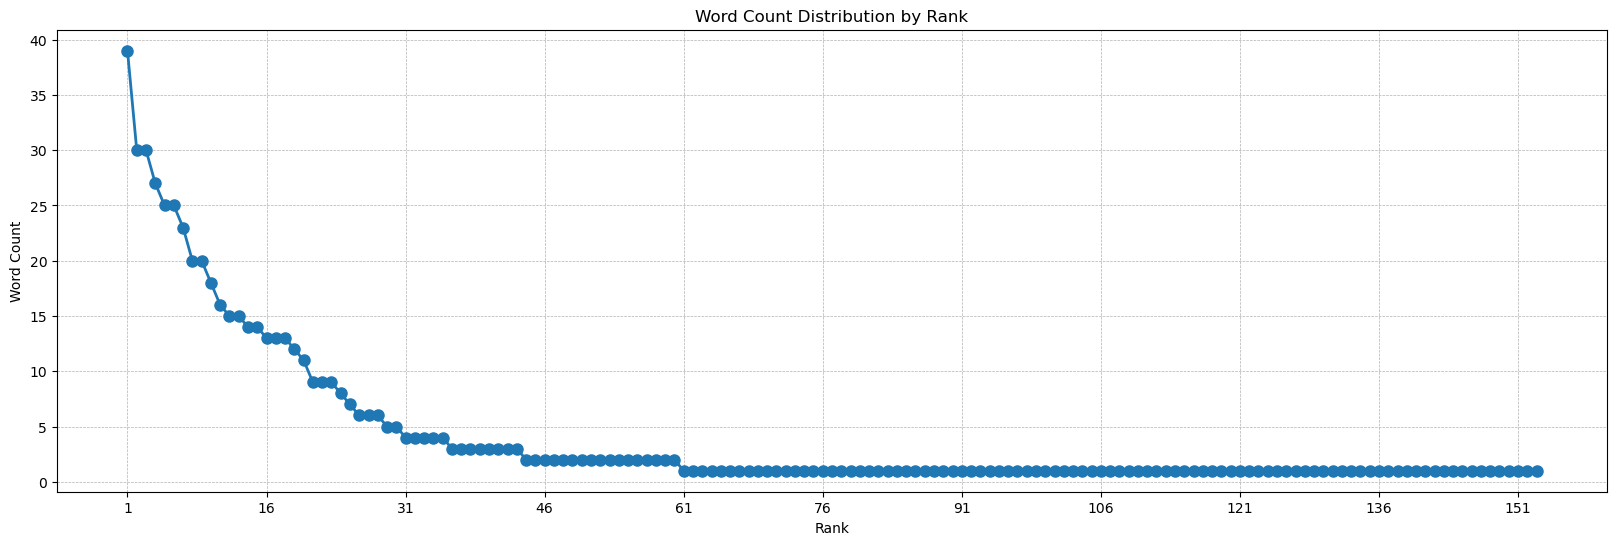

In [13]:
# Sorting the word counts in descending order
sorted_counts = sorted(word_count.values(), reverse=True)

# Plotting the histogram of word counts by rank
plt.figure(figsize=(20, 6))
plt.plot(range(1, len(sorted_counts) + 1), sorted_counts, marker='o', markersize=8, linestyle='-', linewidth=2)

# Adding grid lines
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.title('Word Count Distribution by Rank')
plt.xlabel('Rank')
plt.ylabel('Word Count')
plt.xticks(range(1, len(sorted_counts) + 1, max(1, len(sorted_counts) // 10)))  # Adjust x-ticks for clarity
plt.show()

- **Steep Initial Drop**: The plot shows a steep drop at the beginning, indicating that a few words have very high counts across the files, which suggests these are likely the most significant or common words related to EPS data.

- **Long Tail**: After the initial drop, the word counts level off, forming a long tail with many words having low counts. These words may be less relevant or could represent noise in the data.

**A reasonable approach could be using "elbow method"--to select the top words until the word count drops significantly. Based on the plot, a good starting point might be to select the top 16 - 20 words.**

In [14]:
# Display the top 20 words
for word, count in word_count.most_common(20):
    print(f"  {word}: {count}")


  diluted: 39
  except: 30
  earnings: 30
  net: 27
  common: 25
  basic: 25
  income: 23
  loss: 20
  data: 20
  thousands: 18
  amounts: 16
  shares: 15
  adjusted: 15
  book: 14
  value: 14
  nongaap: 13
  millions: 13
  dividends: 13
  tangible: 12
  gaap: 11


##### Keywords Analysis Results

| Rank 1   | Word 1          | Count 1    | Rank 2   | Word 2          | Count 2    |
|----------|-----------------|------------|----------|-----------------|------------|
| <1>      | diluted         | 39         | <11>     | amounts         | 16         |
| <2>      | except          | 30         | <12>     | shares          | 15         |
| <3>      | earnings        | 30         | <13>     | adjusted        | 15         |
| <4>      | net             | 27         | <14>     | value           | 14         |
| <5>      | common          | 25         | <15>     | book            | 14         |
| <6>      | basic           | 25         | <16>     | millions        | 13         |
| <7>      | income          | 23         | <17>     | nongaap         | 13         |
| <8>      | loss            | 20         | <18>     | dividends       | 13         |
| <9>      | data            | 20         | <19>     | tangible        | 12         |
| <10>     | thousands       | 18         | <20>     | gaap            | 11         |

**Key Financial Terms**: Frequent words like "basic", "diluted," "earnings," "net," "income," and "loss" suggest the documents focus heavily on EPS-related metrics.

In [15]:
# Calculate the total number of terms before filtering
total_terms_before = sum(len(phrases) for phrases in filtered_eps_data.values())

# Define key terms with regex patterns
key_terms_patterns = [
    r'\beps\b',
    r'\bincome\b',
    r'\bloss\b',
    r'\bearn\w*\b',   # Matches "earn", "earning", "earnings", etc.
    r'\bdiluted\b',
    r'\bbasic\b'
]

# Function to check if any key term pattern matches in a phrase
def matches_key_terms(phrase, patterns):
    return any(re.search(pattern, phrase.lower()) for pattern in patterns)

In [16]:
# Further filter the filtered_eps_data using regex for variations
further_filtered_eps_data = {}

for file, phrases in filtered_eps_data.items():
    filtered_phrases = set()
    for phrase in phrases:
        # Keep the phrase if it matches any key term pattern
        if matches_key_terms(phrase, key_terms_patterns):
            filtered_phrases.add(phrase)
    
    # Update the dictionary with further filtered phrases
    further_filtered_eps_data[file] = filtered_phrases

# Calculate the total number of terms after filtering
total_terms_after = sum(len(phrases) for phrases in further_filtered_eps_data.values())

# Calculate the difference
diff = total_terms_before - total_terms_after

# Output the results
print(f"Total number of terms before filtering: {total_terms_before}")
print(f"Total number of terms after filtering: {total_terms_after}")
print(f"Difference: {diff}")

Total number of terms before filtering: 318
Total number of terms after filtering: 193
Difference: 125


In [17]:
# Print the filtered phrases for each file
for file, phrases in further_filtered_eps_data.items():
    print(f"\nFile: {file}")
    for phrase in phrases:
        print(f"  - {phrase}")


File: 0000875320-20-000014.html
  - gaap net income per share - diluted
  - shares used in diluted per share calculations:
  - net income per common share:
  - non-gaap net income per share - diluted
  - net income per diluted common share:

File: 0001165002-20-000083.html
  - earnings per share:
  - economic eps

File: 0001423689-20-000040.html
  - net income (loss) per common share - basic
  - comprehensive income (loss) per common share - basic
  - net income (loss) per common share - diluted
  - net spread and dollar roll income per common share - diluted
  - estimated reit taxable income per common share - basic
  - net spread and dollar roll income per common share - basic
  - comprehensive income (loss) per common share - diluted
  - estimated reit taxable income per common share - diluted
  - ending cumulative non-deductible net capital loss per common share

File: 0001299709-20-000078.html
  - diluted eps
  - adjusted eps (non-gaap)
  - adjusted eps (non-gaap)1

File: 0000846

#### Summary of Insights

1. **Identified EPS-Related Phrases**:
   - The filtering process effectively identified numerous phrases related to Earnings Per Share (EPS) across multiple HTML filings. These phrases include terms like "net income per share," "diluted EPS," and "basic earnings per share," reflecting the different ways companies report EPS data.

2. **Coverage Across Files**:
   - The extraction process successfully spanned a wide range of files, demonstrating that the filtering criteria were broad enough to capture relevant phrases from various sources.

#### Limitations:

1. **Inclusion of Irrelevant Phrases**:
   - Despite the filtering, many phrases that are not directly relevant to EPS calculations remain in the results. For instance, phrases like "shares used in diluted per share calculations" may not provide the precise EPS values we aim to extract.

2. **Over-Inclusiveness**:
   - The broad criteria used for filtering allowed for the capture of a wide array of phrases, some of which may not directly relate to EPS figures but instead to peripheral information such as share counts or reconciliation of GAAP and non-GAAP measures.

3. **Ambiguity in Some Terms**:
   - Certain phrases, while containing key terms like "earnings" or "share," may refer to different financial metrics or calculations that are not relevant to the core EPS value we seek. This introduces ambiguity and can dilute the effectiveness of the filtering process.

4. **Complexity in Non-GAAP Reporting**:
   - The presence of non-GAAP terms like "adjusted EPS" or "economic EPS" adds complexity, as these metrics may vary significantly across filings and may not always align with standard EPS calculations.

<br>

**Given these limitations, the next step involves a more structured approach to extracting relevant EPS data by analyzing the HTML file's underlying data structure.**


### C. Data Structure Analysis

To improve the accuracy and relevance of our EPS data extraction, it's essential to understand the underlying structure of the HTML documents. By analyzing the HTML structure, we can identify consistent patterns and elements that house the desired financial data. This analysis will allow us to develop a more targeted approach to extract EPS values and associated terms, aligning our method with the key requirements such as prioritizing basic EPS, handling multiple EPS entries, and correctly interpreting negative values.


#### Transform Tables into Structured Data

The first step in our data structure analysis involves transforming the tabular content within the HTML files into a structured data format. This process will enable us to systematically analyze and extract relevant EPS-related information. 

1. **Identify and Extract Tables**: 
   - Use BeautifulSoup to locate all `<table>` elements within each HTML file. These tables often contain financial data presented in a structured format.

2. **Parse Table Content**:
   - For each table, extract the content of rows (`<tr>`) and cells (`<td>` or `<th>`), converting them into a structured format like lists or dictionaries. This allows for easy manipulation and filtering of the data.

3. **Tokenize and Normalize Data**:
   - Tokenize the text within each cell to ensure that the content is in a consistent, lowercased format. This will help in matching terms like "EPS" or "earnings per share" across different filings.

4. **Structure the Data**:
   - Convert the parsed table data into a more structured format, such as a list of dictionaries, where each dictionary represents a row in the table, with keys corresponding to the column headers.


In [18]:
from bs4 import BeautifulSoup
import pandas as pd

# Verify the data size
html_files = [f for f in os.listdir(data_path) if f.endswith('.html')]
total_files = len(html_files)
print(f"Found {total_files} HTML files.")

Found 50 HTML files.


In [167]:
def table_matches_criteria(table):
    """
    Checks if the table contains at least one row that fulfills all criteria:
    1. Contains the primary keyword "eps".
    2. Contains both secondary keywords "per" and "share".
    3. Contains any of the conditional keywords like "earn", "net", "income", "loss".
    
    Parameters:
    table (BeautifulSoup element): The table element to check.
    
    Returns:
    bool: True if at least one row fulfills all criteria, otherwise False.
    """
    primary_keywords = ["eps"]
    secondary_keywords = ["per", "share"]
    conditional_keywords = ["earn", "earning", "earnings", "income", "loss"]

    for row in table.find_all('tr'):
        cells_text = [cell.get_text(strip=True).lower() for cell in row.find_all(['td', 'th'])]

        # Check for primary keywords ("eps")
        contains_eps = any(keyword in " ".join(cells_text) for keyword in primary_keywords)
        
        # Check for secondary keywords ("per" and "share") and conditional keywords ("earn", "net", etc.)
        contains_per_share = all(keyword in " ".join(cells_text) for keyword in secondary_keywords)
        contains_conditional = any(keyword in " ".join(cells_text) for keyword in conditional_keywords)
        
        # If all conditions are met within the same row, return True
        if contains_eps or (contains_per_share and contains_conditional):
            return True

    # If no row meets all the criteria, return False
    return False

**Try to automatically parse html files**

In [169]:
# Process each HTML file
for file_name in html_files[:1]:
    file_path = os.path.join(data_path, file_name)
    
    # Define the name of the file
    current_file_name = os.path.splitext(file_name)[0]  # Strip off the extension for simplicity
    
    # Open and read the HTML file
    with open(file_path, 'r', encoding='utf-8') as file:
        html_content = file.read()
    
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(html_content, 'lxml')
    
    # Find all tables in the HTML
    tables = soup.find_all('table')
    
    # Print the name of the current file being processed
    print(f"Processing file: {current_file_name}")
    
    # Loop through the tables and filter based on keywords
    for i, table in enumerate(tables):
        if table_matches_criteria(table):
            df = pd.read_html(str(table))[0]
            
            # Print the table index and dataframe
            print(f"\nTable {i+1} (Keyword Match):")
            display(df)
    
    print("\n" + "="*80 + "\n")  # Separator between files

Processing file: 0000875320-20-000014

Table 1 (Keyword Match):


/tmp/ipykernel_1248/3020900197.py:24: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


,0,1,2,3,4,5,6,7,8,9,10,11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,"Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,",NaN,%
3,NaN,2020,2020,2020,2020,NaN,2019,2019,2019,2019,NaN,Change
4,NaN,"(in millions, except per share amounts)","(in millions, except per share amounts)","(in millions, except per share amounts)","(in millions, except per share amounts)","(in millions, except per share amounts)","(in millions, except per share amounts)","(in millions, except per share amounts)","(in millions, except per share amounts)","(in millions, except per share amounts)","(in millions, except per share amounts)","(in millions, except per share amounts)"
5,"Product revenues, net",$,1515,NaN,NaN,NaN,$,857,NaN,NaN,NaN,77%
6,TRIKAFTA,$,895,NaN,NaN,NaN,$,—,NaN,NaN,NaN,NaN
7,SYMDEKO/SYMKEVI,$,173,NaN,NaN,NaN,$,320,NaN,NaN,NaN,NaN
8,ORKAMBI,$,234,NaN,NaN,NaN,$,293,NaN,NaN,NaN,NaN
9,KALYDECO,$,213,NaN,NaN,NaN,$,244,NaN,NaN,NaN,NaN



Table 18 (Keyword Match):


/tmp/ipykernel_1248/3020900197.py:24: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


,0,1,2,3,4,5,6,7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,"Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,"
3,NaN,2020,2020,2020,NaN,2019,2019,2019
4,Revenues:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"Product revenues, net",$,1515107,NaN,NaN,$,857253,NaN
6,Collaboration and royalty revenues,—,—,NaN,NaN,1182,1182,NaN
7,Total revenues,1515107,1515107,NaN,NaN,858435,858435,NaN
8,Costs and expenses:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Cost of sales,162497,162497,NaN,NaN,95092,95092,NaN



Table 19 (Keyword Match):


/tmp/ipykernel_1248/3020900197.py:24: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


,0,1,2,3,4,5,6,7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,"Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,","Three Months Ended March 31,"
3,NaN,2020,2020,2020,NaN,2019,2019,2019
4,GAAP net income,$,602753,NaN,NaN,$,268631,NaN
5,Stock-based compensation expense,115706,115706,NaN,NaN,93791,93791,NaN
6,Decrease (increase) in fair value of strategic...,44870,44870,NaN,NaN,"(43,551","(43,551",)
7,Increase in fair value of contingent considera...,1600,1600,NaN,NaN,—,—,NaN
8,Collaborative revenues and expenses (3),36250,36250,NaN,NaN,6351,6351,NaN
9,Acquisition-related costs (4),2883,2883,NaN,NaN,—,—,NaN


#### Insights form the Table Parsing Attempt

##### Observations:
1. **Misalignment of Data:**
   - The table appears to have many "NaN" values, which suggests that the columns are not properly aligned with the corresponding headers.
   - For example, in rows that should contain financial data, such as "GAAP Net income per share - diluted," the values are spread across multiple columns, leading to confusion and loss of information clarity.

2. **Merged or Spanned Cells:**
   - The original HTML table might have used `colspan` or `rowspan` attributes to merge cells, which can cause issues when converting the HTML table directly into a DataFrame. These merged cells can lead to misaligned columns if not handled correctly.

3. **Repetitive Headers:**
   - The presence of repeated headers like "Three Months Ended March 31," across multiple columns could indicate that the data was intended to be grouped but has been split incorrectly across columns.

4. **Non-Numeric Data in Numeric Columns:**
   - Cells intended for numeric values often contain text descriptions (e.g., "(in millions, except per share amounts)"), which can disrupt the alignment and proper interpretation of the data.


##### Implications:
- **Manual Adjustment Required:** Automatic table extraction may require significant manual intervention to correct misalignments and properly organize the data into coherent columns.
- **Challenges with Automated Tools:** The complexity of the table's original formatting, especially with merged cells and non-standard structures, poses challenges for automated extraction tools, which are often not equipped to handle these issues without additional logic.

<br>

In [181]:
import re

def process_html_and_print_tables(html_files):
    """
    Main function to process HTML files, extract and print tables that match specific criteria.
    
    Parameters:
    html_files (list): List of HTML file names to process.
    """
    index = 1
    for file_name in html_files:
        print(f"Processing file: {index}. {file_name}")
        file_path = os.path.join(data_path, file_name)
        
        # Read the content of the HTML file
        html_content = read_html_file(file_path)
        
        # Parse HTML content to extract tables
        tables = parse_html_content(html_content)
        
        index += 1
        
        for i, table in enumerate(tables):
            if table_matches_criteria(table):
                # Process and clean table rows
                processed_rows = process_table(table)
                cleaned_rows = clean_rows(processed_rows)
                reprocessed_rows = reprocess_rows(cleaned_rows)
                combined_rows = combine_outer_with_inner_rows(reprocessed_rows)
                shifted_rows = shift_columns_if_needed(combined_rows)
                
                # Filter tables based on the cleaned and reprocessed rows
                if filter_table_by_column_count(shifted_rows):
                    print(f"\nMatched Table {i+1} in {file_name}:")
                    
                    # Print the cleaned and formatted table
                    print_table(shifted_rows)

                    print("=" * 80)

def read_html_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def parse_html_content(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    return soup.find_all('table')

def process_table(table):
    """
    Processes the table by extracting and cleaning the rows.
    
    Parameters:
    table (element): The table element to process.
    
    Returns:
    list: List of processed rows.
    """
    rows = table.find_all('tr')
    processed_rows = []
    max_columns = 0
    
    for row in rows:
        processed_row, num_columns = process_row(row)
        processed_rows.append(processed_row)
        max_columns = max(max_columns, num_columns)
    
    return processed_rows

def process_row(row):
    """
    Processes each row by merging specific cell contents and removing unnecessary spaces.
    
    Parameters:
    row (element): The row element to process.
    
    Returns:
    tuple: A list representing the processed row and the number of columns in the row.
    """
    cells = row.find_all(['td', 'th'])
    row_data = []
    skip_next = False

    for idx, cell in enumerate(cells):
        if skip_next:
            skip_next = False
            continue

        cell_text = cell.get_text(strip=True)

        # Merge "$" symbol with the next number
        if cell_text == "$" and idx < len(cells) - 1:
            merged_value = f"${cells[idx + 1].get_text(strip=True)}"
            row_data.append(merged_value)
            skip_next = True
        # Merge negative numbers with their parentheses across different cells
        elif cell_text.startswith("(") and idx < len(cells) - 1:
            next_cell_text = cells[idx + 1].get_text(strip=True)
            # Check if next cell ends with ")"
            if next_cell_text.endswith(")"):
                merged_value = f"{cell_text}{next_cell_text}"
                row_data.append(merged_value)
                skip_next = True
            else:
                row_data.append(cell_text)
        # Handle case where ")" is in a separate cell
        elif cell_text.endswith(")") and len(row_data) > 0 and row_data[-1].startswith("("):
            row_data[-1] = f"{row_data[-1]}{cell_text}"
        # Merge numbers with "%" symbol
        elif cell_text.replace('.', '', 1).isdigit() and idx < len(cells) - 1 and cells[idx + 1].get_text(strip=True) == "%":
            merged_value = f"{cell_text}%"
            row_data.append(merged_value)
            skip_next = True
        else:
            row_data.append(cell_text)

    return row_data, len(row_data)


def clean_rows(processed_rows):
    """
    Cleans the processed rows by removing empty columns and empty rows.
    
    Parameters:
    processed_rows (list): List of processed rows to clean.
    
    Returns:
    list: List of cleaned rows.
    """
    cleaned_rows = []

    for row in processed_rows:
        # Keep the first column even if it is empty, remove other empty columns
        if row[0].strip() == "":
            cleaned_row = [row[0]] + [cell for cell in row[1:] if cell.strip()]
        else:
            cleaned_row = [cell for cell in row if cell.strip()]
        cleaned_rows.append(cleaned_row)
    
    # Remove completely empty rows
    cleaned_rows = [row for row in cleaned_rows if any(cell.strip() for cell in row)]
    
    return cleaned_rows

def reprocess_rows(cleaned_rows):
    """
    Reprocesses rows to handle any remaining cases such as cells containing both '(' and ')' or separated % symbols.
    Also, splits cells if they contain exactly two pairs of parentheses, excluding the first column.
    
    Parameters:
    cleaned_rows (list): List of cleaned rows to reprocess.
    
    Returns:
    list: List of reprocessed rows.
    """
    reprocessed_rows = []

    for row in cleaned_rows:
        reprocessed_row = []
        skip_next = False

        for idx, cell in enumerate(row):
            if skip_next:
                skip_next = False
                continue

            # Ensure that the first column is not split
            if idx == 0:
                reprocessed_row.append(cell)
                continue

            # Check if a cell contains "(" and another cell in the row contains ")"
            if "(" in cell and idx < len(row) - 1 and ")" in row[idx + 1]:
                merged_value = f"{cell}{row[idx + 1]}"
                reprocessed_row.append(merged_value)
                skip_next = True
            # Check if a cell is a number and the next cell is "%"
            elif cell.replace('.', '', 1).isdigit() and idx < len(row) - 1 and row[idx + 1] == "%":
                merged_value = f"{cell}%"
                reprocessed_row.append(merged_value)
                skip_next = True
            # Handle cases where % sign and parentheses are separated
            elif "(" in cell and idx < len(row) - 1 and ")" in row[idx + 1]:
                merged_value = f"{cell}{row[idx + 1]}"
                reprocessed_row.append(merged_value)
                skip_next = True
            else:
                reprocessed_row.append(cell)
        
        # After merging, check each cell for exactly two pairs of parentheses and split them if needed
        final_row = []
        for idx, cell in enumerate(reprocessed_row):
            # Ensure that the first column is not split
            if idx == 0:
                final_row.append(cell)
                continue

            open_parens_count = cell.count('(')
            close_parens_count = cell.count(')')
            
            # Only split if there are exactly two pairs of parentheses and it's not the first column
            if open_parens_count == 2 and close_parens_count == 2:
                # Split based on multiple sets of parentheses
                parts = re.findall(r'\(.*?\)|[^()]+', cell)
                final_row.extend([part.strip() for part in parts if part.strip()])
            else:
                final_row.append(cell)

        reprocessed_rows.append(final_row)

    return reprocessed_rows


def print_table(cleaned_rows):
    for row in cleaned_rows:
        # Adjust the spacing: first column wider for descriptions
        formatted_row = f"{row[0]:<150}" + " | ".join(f"{cell:<20}" for cell in row[1:])
        print(f"| {formatted_row} |")
        
def filter_table_by_column_count(cleaned_rows):
    """
    Filters out tables with less than 2 rows or tables that have fewer than 2 columns with non-empty data.

    Parameters:
    cleaned_rows (list): List of cleaned rows to filter.

    Returns:
    bool: True if the table has 2 or more rows with non-empty data in at least 2 columns.
    """
    if len(cleaned_rows) < 2:
        return False
    
    # Check for meaningful data in at least 2 columns across all rows
    for row in cleaned_rows:
        non_empty_columns = sum(1 for cell in row if cell.strip())
        if non_empty_columns >= 2:
            return True
            
    return False

def combine_outer_with_inner_rows(reprocessed_rows):
    """
    Combines outer rows (those with a colon in the first cell) with each of the inner rows that follow them.
    
    Parameters:
    reprocessed_rows (list): List of rows that have been reprocessed.
    
    Returns:
    list: List of rows with outer rows combined with each inner row.
    """
    combined_rows = []
    i = 0

    while i < len(reprocessed_rows):
        current_row = reprocessed_rows[i]

        # Check if the current row has a colon in the first cell
        if ":" in current_row[0] and i < len(reprocessed_rows) - 1:
            # Loop through the subsequent rows until the next outer row or end of list
            j = i + 1
            while j < len(reprocessed_rows) and len(reprocessed_rows[j]) > 1:
                # Combine the outer row with the inner data row
                combined_row = [f"{current_row[0]} - {reprocessed_rows[j][0]}"] + reprocessed_rows[j][1:]
                combined_rows.append(combined_row)
                j += 1

            # Move to the row after the last inner row
            i = j
        else:
            combined_rows.append(current_row)
            i += 1

    return combined_rows

def shift_columns_if_needed(rows):
    """
    Shifts columns leftward for rows where the first column is empty and the second column is not, 
    but only for those specific rows.
    
    Parameters:
    rows (list): List of rows to check and adjust.
    
    Returns:
    list: List of adjusted rows with columns shifted leftward where needed.
    """
    shifted_rows = []
    
    for row in rows:
        # Check if the first column is empty and the second column is not
        if row[0].strip() == "" and row[1].strip() != "":
            # Shift leftward by removing the first column and appending an empty column at the end
            shifted_row = row[1:] + [""]
            shifted_rows.append(shifted_row)
        else:
            shifted_rows.append(row)
    
    return shifted_rows


In [182]:
process_html_and_print_tables(html_files)

Processing file: 1. 0000875320-20-000014.html

Matched Table 1 in 0000875320-20-000014.html:
| Three Months Ended March 31,                                                                                                                          %                    |                      |
| 2020                                                                                                                                                  2019                 | Change               |                      |
| (in millions, except per share amounts)                                                                                                                                    |
| Product revenues, net                                                                                                                                 $1,515               | $857                 | 77%                  |
| TRIKAFTA                                                                                  